In [1]:
import numpy as np
from numpy.linalg import norm
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

from matplotlib.colors import ListedColormap
%matplotlib inline
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
import sklearn.linear_model
import os.path

import time

from NeuralNet import NeuralNet
from utils.json import read_from_json
from utils.nnsetup import *
from utils.attackperformance import *
from attacks.attacks import Attack

np.random.seed(1)

In [2]:
X_train, Y_train, Y_train_e, X_test, Y_test = get_datasets()

In [3]:
X_test_c = X_test[:10000].copy()
Y_test_c = Y_test[:10000].copy()

In [4]:
test_epsilon = [1/255]
#test_epsilon = [1/255, 3/255, 5/255, 10/255, 15/255, 30/255, 50/255, 80/255, 120/255]
ignore_not_adversarial = False

In [5]:
cls = getNN("nets/main_nn_300", 1)

In [6]:
df, insights, initial, adversarial = get_insights(cls, test_epsilon, X_test_c, Y_test_c,
                                                  ignore_not_adversarial=ignore_not_adversarial)
df

epsilon = 0.00392156862745098
840 instances, 840 adversaries
1680 instances, 1680 adversaries
2520 instances, 2520 adversaries
3360 instances, 3360 adversaries
4200 instances, 4200 adversaries
5040 instances, 5040 adversaries
5880 instances, 5880 adversaries
6720 instances, 6720 adversaries
7560 instances, 7560 adversaries
8400 instances, 8400 adversaries
8400 instances, 8400 adversaries
------------------------------
total time: 284.0853021144867
total iter: 161968


,target,successful attempts,epsilon
0,NaN,8400.0,0.003922


In [7]:
insights.head()

,original,prediction,iterations,epsilon,L2 norm
0,7.0,9.0,25.0,0.003922,2.064217
1,3.0,5.0,28.0,0.003922,2.165040
2,9.0,4.0,2.0,0.003922,0.161214
3,8.0,2.0,13.0,0.003922,1.091352
4,6.0,2.0,18.0,0.003922,1.589982


In [8]:
cls_dist = getNN("nets/distilled_nn_100_T_7", 1)

In [9]:
df_dist, insights_dist, initial_dist, adversarial_dist = get_insights(cls_dist, test_epsilon, X_test_c, Y_test_c,
                                                                      ignore_not_adversarial=ignore_not_adversarial)
df_dist

epsilon = 0.00392156862745098
840 instances, 840 adversaries
1680 instances, 1680 adversaries
2520 instances, 2520 adversaries
3360 instances, 3360 adversaries
4200 instances, 4200 adversaries
5040 instances, 5040 adversaries
5880 instances, 5880 adversaries
6720 instances, 6720 adversaries
7560 instances, 7560 adversaries
8400 instances, 8400 adversaries
8400 instances, 8400 adversaries
------------------------------
total time: 307.40299439430237
total iter: 181394


,target,successful attempts,epsilon
0,NaN,8400.0,0.003922


In [10]:
insights_dist.head()

,original,prediction,iterations,epsilon,L2 norm
0,7.0,9.0,38.0,0.003922,2.915522
1,3.0,5.0,49.0,0.003922,3.815350
2,9.0,4.0,15.0,0.003922,1.227163
3,8.0,2.0,18.0,0.003922,1.496766
4,6.0,2.0,25.0,0.003922,2.149485


In [11]:
n_iter = max(max(insights['iterations']), max(insights_dist['iterations']))
iterations = np.arange(n_iter)
n_iter

87.0

In [12]:
accuracy = []
accuracy_dist = []
for i in iterations:
  accuracy.append(1 - sum(insights['iterations']<=i)/insights.shape[0])
  accuracy_dist.append(1 - sum(insights_dist['iterations']<=i)/insights_dist.shape[0])

In [13]:
distance = []
distance_dist = []
ticks = np.linspace(np.min(insights['L2 norm']), np.max(insights['L2 norm']), 100)
for i in ticks:
  distance.append(1 - sum(insights['L2 norm']<=i)/insights.shape[0])
  distance_dist.append(1 - sum(insights_dist['L2 norm']<=i)/insights_dist.shape[0])

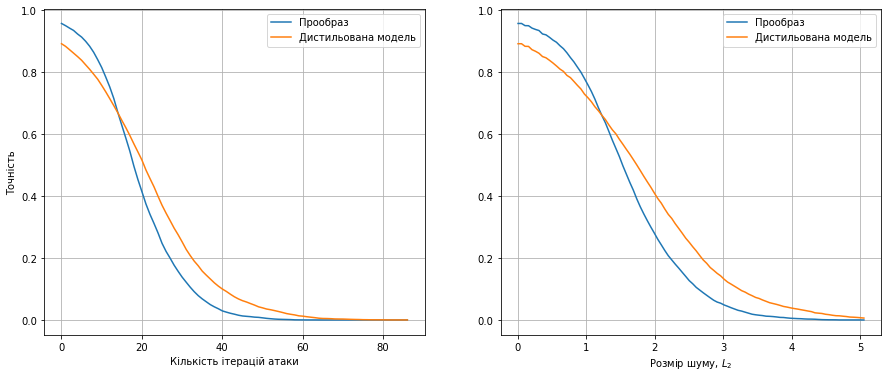

In [14]:
def set_axis(ax):
  ax.set_axisbelow(True)
  ax.grid()
  ax.legend()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15, 6))

ax1.plot(iterations, accuracy, label='Прообраз')
ax1.plot(iterations, accuracy_dist, label='Дистильована модель')
ax1.set_xlabel('Кількість ітерацій атаки')
ax1.set_ylabel('Точність')
set_axis(ax1)

ax2.plot(ticks, distance, label='Прообраз')
ax2.plot(ticks, distance_dist, label='Дистильована модель')
ax2.set_xlabel('Розмір шуму, $L_2$')
set_axis(ax2)

plt.savefig("images/distAllT.pdf", bbox_inches = 'tight', pad_inches = 0)

In [15]:
r_o =  robustness(initial, adversarial)
r_d_7 = robustness(initial_dist, adversarial_dist)
print('original', r_o)
print('defended', r_d_7)

original 0.5394695727113946
defended 0.6383067947416767


In [16]:
(r_d_7 - r_o)/r_o

0.18321185666417195

In [17]:
x_T = [1, 2, 7, 10, 20, 30, 40]
y_o = [0.5394695727113946 for _ in x_T]
y_r_d = [0.6125116365761678, 0.6150069675061154, 0.6383067947416767, 0.6408441519464926, 0.638219608438047, 0.6046881289549533, 0.5591443923632143]
y_r_d_p = [0.13539607710896648, 0.14002160384146772, 0.18321185666417195, 0.18791528635356664, 0.18305024179645754, 0.12089385489485108, 0.036470675357895214]

No handles with labels found to put in legend.


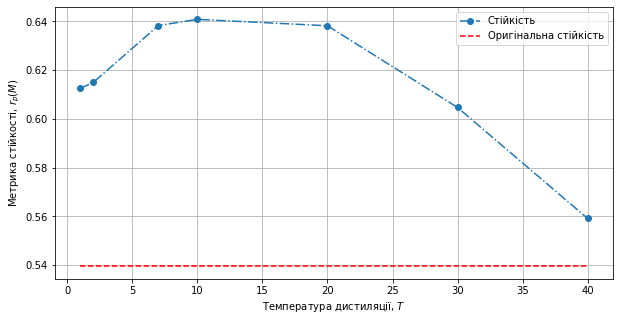

In [18]:
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(111)

set_axis(ax1)

ax1.plot(x_T, y_r_d, 'o-.', label='Стійкість')
ax1.plot(x_T, y_o, 'r--', label='Оригінальна стійкість')

ax1.set_ylabel('Метрика стійкості, $r_p(M)$')
ax1.set_xlabel('Температура дистиляції, $T$')
ax1.legend()

plt.savefig("images/robustness.pdf", bbox_inches = 'tight', pad_inches = 0)

In [19]:
if len(test_epsilon) > 1:
  plt.plot(test_epsilon, 1 - df['successful attempts']/300, label='without defence')
  plt.plot(test_epsilon, 1 - df_dist['successful attempts']/300, label='distilled')
  plt.legend()
  plt.show()

In [20]:
Y_train_hat = cls.predict(X_train)
Y_test_hat = cls.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.9702678571428571
0.9580952380952381


In [21]:
Y_train_hat = cls_dist.predict(X_train)
Y_test_hat = cls_dist.predict(X_test)

print(accuracy_score(Y_train, Y_train_hat))
print(accuracy_score(Y_test, Y_test_hat))

0.8969047619047619
0.8926190476190476
